In [68]:
#from torchvision.datasets import CIFAR10
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

# affine = transforms.RandomAffine([-30, 30], scale=(0.8, 1.2))  # 回転とリサイズ
# flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
# normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
# to_tensor = transforms.ToTensor()

# transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
# transform_test = transforms.Compose([to_tensor, normalize])
# cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
# cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# # DataLoaderの設定
# batch_size = 64
# train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision

In [70]:
print(torch.cuda.is_available())
torch.cuda.current_device()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

True


'cuda'

In [71]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),      #データ拡張：ランダムに反転   ＊＊＊エポック毎にランダムに違う画像になる。数が増える訳ではない＊＊＊
    transforms.ColorJitter(),               #データ拡張：ランダムに色彩を変える
    transforms.RandomRotation(10),          #データ拡張：ランダムに回転 プラスマイナス１０度
    #transforms.Resize((224, 224)),          #画像サイズバラバラなのをリサイズ  
    transforms.Resize((32, 32)),          #画像サイズバラバラなのをリサイズ  
    transforms.ToTensor(),                  #GPUへ (チャネルの並び替え含む)
    transforms.Normalize((0.5, ), (0.5,))   #平均と標準偏差を０．５になるように正規化                         
])

valid_transform = transforms.Compose([
    #transforms.Resize((224, 224)),         #画像サイズバラバラなのをリサイズ   
    transforms.Resize((32, 32)),         #画像サイズバラバラなのをリサイズ   
    transforms.ToTensor(),                 #画像をtensorクラスに変換 チャネルファーストへ入れ替えと値を０－１へ。
    transforms.Normalize((0.5,), (0.5,))   #平均と標準偏差を０．５になるように正規化                               
])



In [72]:
#下位のフォルダごとに画像が分かれている場合はImageFolderで読み込む。 下位フォルダごとにラベル付けされる。
train_dataset = datasets.ImageFolder("./data_train_all", transform=train_transform)    #フォルダから画像をとってくる
valid_dataset = datasets.ImageFolder("./data_valid", transform=valid_transform)    #検証用

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)   #画像をデータローダへ渡す
test_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True)  #検証用

In [73]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数, フィルタサイズ)
        self.relu = nn.ReLU()  # ReLU
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, 領域の間隔）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [74]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

val_accs = []

# 学習
for i in range(25):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    val_running_acc = 0.0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
        val_pred = torch.argmax(y, dim=1)
        val_running_acc += torch.mean(val_pred.eq(t).float())

    loss_test /= j+1
    record_loss_test.append(loss_test)
    val_running_acc /= len(test_loader)
    val_accs.append(val_running_acc)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.3331477046012878 Loss_Test: 1.0639179689543588
Epoch: 1 Loss_Train: 1.0531123327581506 Loss_Test: 0.9229698181152344
Epoch: 2 Loss_Train: 0.877520490633814 Loss_Test: 0.7731354577200753
Epoch: 3 Loss_Train: 0.8618994763022975 Loss_Test: 0.7914740017482212
Epoch: 4 Loss_Train: 0.810753262356708 Loss_Test: 0.7198167272976467
Epoch: 5 Loss_Train: 0.8271960647482621 Loss_Test: 0.7622960635593959
Epoch: 6 Loss_Train: 0.7911301145428106 Loss_Test: 0.7541131377220154
Epoch: 7 Loss_Train: 0.8159670398423546 Loss_Test: 0.6892966883523124
Epoch: 8 Loss_Train: 0.7838775405758306 Loss_Test: 0.7596810034343174
Epoch: 9 Loss_Train: 0.7796695263762223 Loss_Test: 0.7296374014445713
Epoch: 10 Loss_Train: 0.7597827534926566 Loss_Test: 0.6693227248532432
Epoch: 11 Loss_Train: 0.7431155725529319 Loss_Test: 0.6377093281064715
Epoch: 12 Loss_Train: 0.7296085969397896 Loss_Test: 0.6079439989158085
Epoch: 13 Loss_Train: 0.7333584843497527 Loss_Test: 0.6555195025035313
Epoch: 14 Loss_Tra

In [75]:
#====== モデルの保存 =======
import torch
torch.save(net.state_dict(), "./model_cnn.pth")

# モデルを保存する。
torch.save(net, "model_cnn_all.pth")

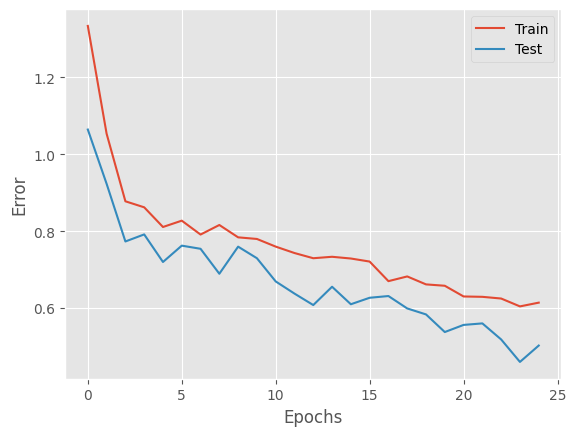

In [76]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

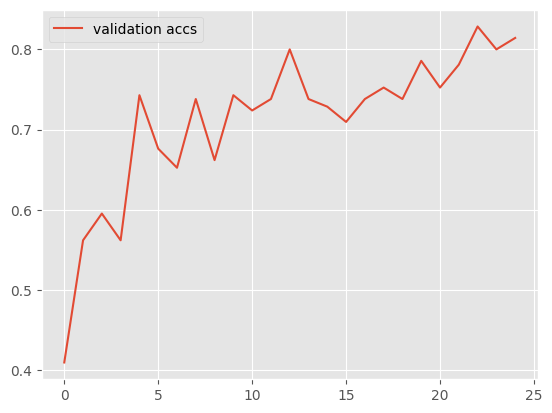

In [77]:
val_accs_float=[]
for val in val_accs:
    val_accs_float.append(float(val.to('cpu')))   #val_accs はtensor型のリストなので、float型に変換する

plt.style.use("ggplot")
#plt.plot(accs_float, label="train accs")
plt.plot(val_accs_float, label="validation accs")
#plt.plot(val_accs_ave_float, label="validation accs ave")
plt.legend()


In [78]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 79.36507936507937%


In [79]:
from PIL import Image

label = ['0','1','2']

def eval(file):
    preprocess = transforms.Compose([
    #transforms.Resize((224, 224)),  #画像サイズバラバラなのをリサイズ
    transforms.Resize((32, 32)),  #画像サイズバラバラなのをリサイズ
    transforms.ToTensor(),                 #画像をtensorクラスに変換 チャネルファーストへ入れ替えと値を０－１へ。
    transforms.Normalize((0.5,), (0.5,))   #平均と標準偏差を０．５になるように正規化                               
    ])
    img_org = Image.open(file)
    img = preprocess(img_org)
    img_batch = img[None]  # PyTorchではバッチ処理が基本なので、1枚の画像の場合も先頭に次元を追加する必要がある。
    img_batch = img_batch.cuda()
    output = net(img_batch)   #予測を行う
    #print(output)
    idx = torch.argmax(output, dim=1)
    idx = int(idx.to('cpu'))
    print(f'{file},{label[idx]} ')  #コンソール出力
        
    return  file, idx


In [80]:
import pathlib
import csv
#device = torch.device('cpu')
#フォルダ内の各ファイルについて予測
fol = r'C:\Users\arwml\py1\28_contest2\data_eval/'
#fol = r'.\data_eval/'
count=[0,0,0]
csv_file = 'result.csv'
result = []

p_temp = pathlib.Path(fol).glob('*.jpg')  #指定フォルダ内のファイル名をリストに取得
for p in p_temp:
    file, idx = eval(fol + p.name)  #予測
    count[idx] += 1 #カウントアップ
    row = file , idx
    result.append(row)

print(f'１は{count[0]}枚です。 ２は {count[1]}枚です。  ３は {count[2]}枚です。 ' ) 

with open("output.tsv", "w" , encoding='utf-8',newline='') as f:
    writer = csv.writer(f,  delimiter='\t')
    writer.writerows(result)

C:\Users\arwml\py1\28_contest2\data_eval/test_0000.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0001.jpg,1 
C:\Users\arwml\py1\28_contest2\data_eval/test_0002.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0003.jpg,0 
C:\Users\arwml\py1\28_contest2\data_eval/test_0004.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0005.jpg,0 
C:\Users\arwml\py1\28_contest2\data_eval/test_0006.jpg,0 
C:\Users\arwml\py1\28_contest2\data_eval/test_0007.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0008.jpg,0 
C:\Users\arwml\py1\28_contest2\data_eval/test_0009.jpg,1 
C:\Users\arwml\py1\28_contest2\data_eval/test_0010.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0011.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0012.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0013.jpg,0 
C:\Users\arwml\py1\28_contest2\data_eval/test_0014.jpg,2 
C:\Users\arwml\py1\28_contest2\data_eval/test_0015.jpg,1 
C:\Users\arwml\py1\28_contest2\data_eval/test_0016.jpg,0 
C:\Users\arwml